# sha512t24u/xxhash VRS experiments

see `requirements.txt` for environment

## basic string hashing

In [1]:
import random
import seaborn as sns
import xxhash
import base64
import hashlib
import pandas as pd

In [2]:
test_sequences = []
# sequences of ACGT increasing exponentially in length
for length in (10**(i / 2) for i in range(1, 15)):
    test_sequences.append("".join(
        [random.choice(["a", "g", "c", "t"]) for _ in range(round(length))]
    ).encode("ascii"))

In [3]:
def xxh(blob):
    return xxhash.xxh128(blob).hexdigest()

def sha512t24u(blob):
    digest_size = 24
    digest = hashlib.sha512(blob).digest()
    tdigest_b64us = base64.urlsafe_b64encode(digest[:digest_size])
    return tdigest_b64us.decode("ascii")

In [4]:
experiment_1_data = []
for sequence in test_sequences:
    xxh_result = %timeit -o xxh(sequence)
    experiment_1_data.append(["xxh", len(sequence), xxh_result.average])
    sha_result = %timeit -o sha512t24u(sequence)
    experiment_1_data.append(["sha", len(sequence), sha_result.average])
df_1 = pd.DataFrame(experiment_1_data, columns=["hash fn", "input length", "running time"])

430 ns ± 18.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.23 µs ± 13.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
418 ns ± 19.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.24 µs ± 27.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
449 ns ± 15.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.24 µs ± 27 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
441 ns ± 9.84 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.24 µs ± 19.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
472 ns ± 23.9 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
1.82 µs ± 274 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
488 ns ± 16.7 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
2.76 µs ± 118 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
589 ns ± 15.6 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)

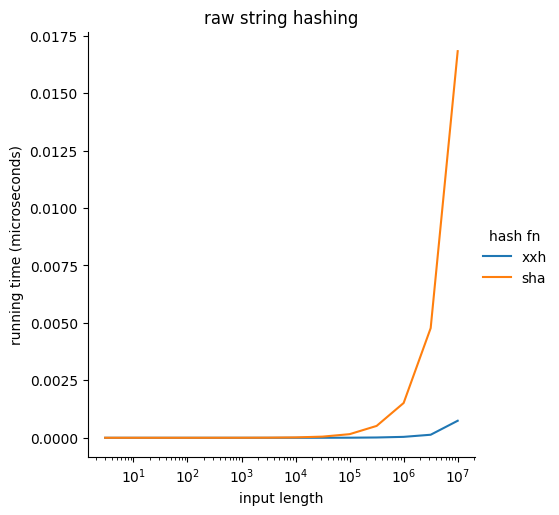

In [5]:
g = sns.relplot(
    data=df_1, x="input length", y="running time", kind="line",
    hue="hash fn"
)
g.set(xscale="log", ylabel="running time (microseconds)", title="raw string hashing")

## basic allele digest generation

`allele` is a pretty standard SNP used in some of the testing notebooks. It's probably the ~shortest JSON dump that you could expect to construct like this, but it's fairly representative of the kinds of variations that we've been benchmarking against (

In [6]:
from ga4gh.core import ga4gh_identify
from ga4gh.vrs import models
from ga4gh.core_xxh import xxh
from ga4gh.core_xxh import ga4gh_identify as ga4gh_identify_xxh
import json
import inspect

In [7]:
allele_dict = {'location': {'end': 55181320,
  'start': 55181319,
  'sequence': {'type': 'SequenceReference',
   'refgetAccession': 'SQ.F-LrLMe1SRpfUZHkQmvkVKFEGaoDeHul'},
  'type': 'SequenceLocation'},
 'state': {'sequence': 'T', 'type': 'LiteralSequenceExpression'},
 'type': 'Allele'}
allele = models.Allele(**allele_dict)
print(len(allele.model_dump_json()))

414


`ga4gh_identify_xxh` is the VRS-Python `ga4gh_identify` function, but using the 128-bit version of `xxhash`, via the Python `xxhash` package:

In [8]:
print(inspect.getsource(xxh))

def xxh(blob):
    return xxhash.xxh128(blob).hexdigest()



In [9]:
%%timeit
ga4gh_identify_xxh(allele)

104 µs ± 4.61 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [10]:
%%timeit
ga4gh_identify(allele)

106 µs ± 3.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


## larger allele digest generation

In [11]:
test_alleles = []
# sequences of ACGT increasing exponentially in length
for length in (10**(i / 2) for i in range(1, 15)):
    sequence = "".join(
        [random.choice(["A", "G", "C", "T"]) for _ in range(round(length))]
    ).encode("ascii")

    test_allele_dict = {
        'location': {
            'end': 55181320,
            'start': 55181319,
            'sequence': {
                'type': 'SequenceReference',
                'refgetAccession': 'SQ.F-LrLMe1SRpfUZHkQmvkVKFEGaoDeHul'},
                'type': 'SequenceLocation'
            },
        'state': {
            'sequence': sequence, 
            'type': 'LiteralSequenceExpression'
        },
        'type': 'Allele'
    }
    test_alleles.append(models.Allele(**test_allele_dict))

In [12]:
experiment_3_data = []
for allele in test_alleles:
    allele_length = len(allele.model_dump_json())
    xxh_result = %timeit -o ga4gh_identify_xxh(allele)
    experiment_3_data.append(["xxh", allele_length, xxh_result.average])
    sha_result = %timeit -o ga4gh_identify(allele)
    experiment_3_data.append(["sha", allele_length, sha_result.average])
df_3 = pd.DataFrame(experiment_3_data, columns=["hash fn", "input length", "running time"])

103 µs ± 4.81 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
110 µs ± 3.66 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
96.1 µs ± 3.69 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
105 µs ± 2.18 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
100 µs ± 5.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
104 µs ± 4.41 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
102 µs ± 4.45 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
105 µs ± 3.16 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
107 µs ± 3.5 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
111 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
107 µs ± 1.96 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
113 µs ± 4.26 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
127 µs ± 4.1 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
149 µs ± 10.9 µs per loop (mean ± std. d

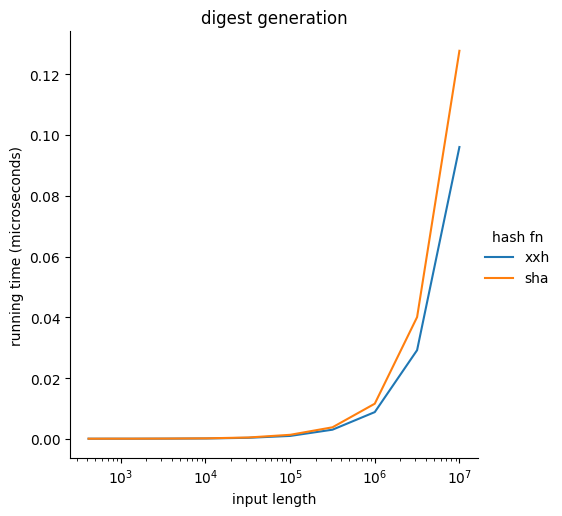

In [13]:
g3 = sns.relplot(
    data=df_3, x="input length", y="running time", kind="line",
    hue="hash fn"
)
g3.set(xscale="log", ylabel="running time (microseconds)", title="digest generation")

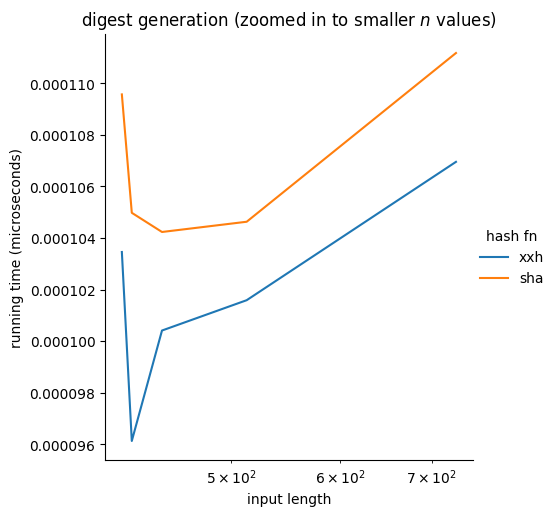

In [15]:
g3 = sns.relplot(
    data=df_3.head(10), x="input length", y="running time", kind="line",
    hue="hash fn"
)
g3.set(
    xscale="log", 
    ylabel="running time (microseconds)", 
    title="digest generation (zoomed in to smaller $n$ values)"
)